In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import json
import pandas as pd

# Path to the folder containing all events
event_dir = "../data/events/"

# Match file for World Cup 2018
matches_fp = "../data/matches/43/3.json"

# Load all match IDs
with open(matches_fp, "r", encoding="utf-8") as f:
    matches = json.load(f)
match_ids = [match['match_id'] for match in matches]

# Load and combine all events
all_events = []
for match_id in match_ids:
    event_path = os.path.join(event_dir, f"{match_id}.json")
    if not os.path.exists(event_path):
        continue
    with open(event_path, "r", encoding="utf-8") as f:
        events = json.load(f)
        for event in events:
            event['match_id'] = match_id
        all_events.extend(events)

# Normalize into a DataFrame
df_events = pd.json_normalize(all_events)

# Select important columns
columns = ['match_id', 'team.name', 'player.name', 'type.name', 'location', 'pass.outcome.name', 'shot.outcome.name']
df_clean = df_events[columns].copy()
df_clean.columns = ['match_id', 'team_name', 'player_name', 'event_type', 'location', 'pass_outcome', 'shot_outcome']

# Save
os.makedirs("../data/interim", exist_ok=True)
df_clean.to_csv("../data/interim/events_combined.csv", index=False)

print("✅ Saved ../data/interim/events_combined.csv")


✅ Saved ../data/interim/events_combined.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
def classify_zone(x_location):
    if x_location < 33:
        return 'DEF_3RD'
    elif x_location < 66:
        return 'MID_3RD'
    else:
        return 'ATT_3RD'



In [4]:
# Load cleaned event data
df = pd.read_csv("../data/interim/events_combined.csv")

# Filter to a single team or match for simplicity
team_df = df[df['team_name'] == 'England'].copy()

# Classify each location into a zone
team_df['zone'] = team_df['location'].dropna().apply(lambda loc: classify_zone(eval(loc)[0]) if isinstance(loc, str) else None)
team_df['zone'] = team_df['zone'].fillna(method='ffill')  # Fill NaNs

# Create transitions
transitions = list(zip(team_df['zone'][:-1], team_df['zone'][1:]))

# Build transition counts
transition_counts = pd.DataFrame(transitions, columns=['from', 'to']).value_counts().unstack().fillna(0)

# Normalize to get probabilities
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0)


C:\Users\shrih\AppData\Local\Temp\ipykernel_5732\3809463927.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  team_df['zone'] = team_df['zone'].fillna(method='ffill')  # Fill NaNs


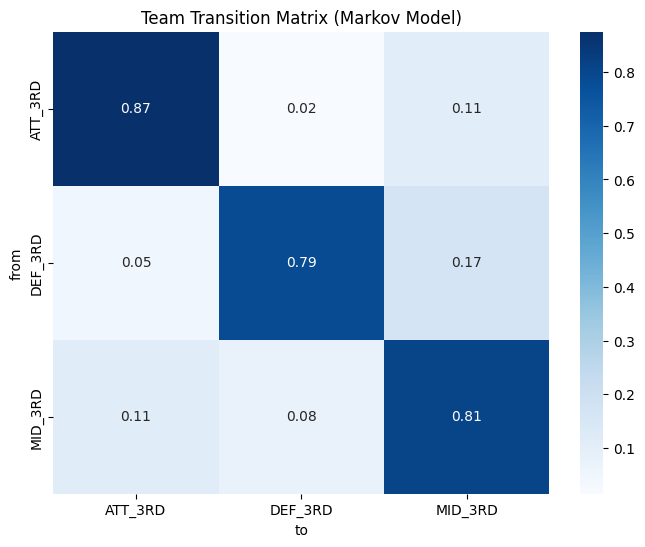

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(transition_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Team Transition Matrix (Markov Model)')
plt.show()


In [6]:
def simulate_possession(transition_matrix, start_state='DEF_3RD', max_steps=20):
    state = start_state
    sequence = [state]
    
    for _ in range(max_steps):
        next_state = np.random.choice(transition_matrix.columns, p=transition_matrix.loc[state].values)
        sequence.append(next_state)
        if next_state in ['SHOT', 'GOAL', 'LOSS']:
            break
        state = next_state
    return sequence

# Example simulation
simulate_possession(transition_matrix)


['DEF_3RD',
 'DEF_3RD',
 'DEF_3RD',
 'DEF_3RD',
 'DEF_3RD',
 'MID_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'MID_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'ATT_3RD',
 'DEF_3RD',
 'DEF_3RD',
 'DEF_3RD',
 'DEF_3RD']

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned event data
df = pd.read_csv('../data/interim/events_combined.csv')


In [10]:
# Keep only events with zone information
df = df[df['zone'].notnull()]

# Sort by match and timestamp (optional but helpful)
df = df.sort_values(['match_id', 'team_name', 'timestamp'])  # assuming you have 'timestamp'


KeyError: 'zone'

In [1]:
import pandas as pd

# Example loading
df = pd.read_csv('../data/interim/events_combined.csv')

# Confirm 'location' exists and extract x-coordinates
df = df[df['location'].notnull()]
df['x'] = df['location'].apply(lambda loc: eval(loc)[0] if isinstance(loc, str) else loc[0])

# Now create zones based on x
def classify_zone(x):
    if x < 40:
        return 'DEF_3RD'
    elif x < 70:
        return 'MID_3RD'
    else:
        return 'ATT_3RD'

df['zone'] = df['x'].apply(classify_zone)


In [3]:
# Keep only events with zone information
df = df[df['zone'].notnull()]

df = df.sort_values(['match_id', 'team_name'])  # no timestamp



In [4]:
df['next_zone'] = df.groupby(['match_id', 'team_name'])['zone'].shift(-1)
df_transitions = df.dropna(subset=['next_zone'])


In [5]:
transition_counts = (
    df_transitions.groupby(['zone', 'next_zone'])
    .size()
    .unstack(fill_value=0)
)


In [6]:
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)


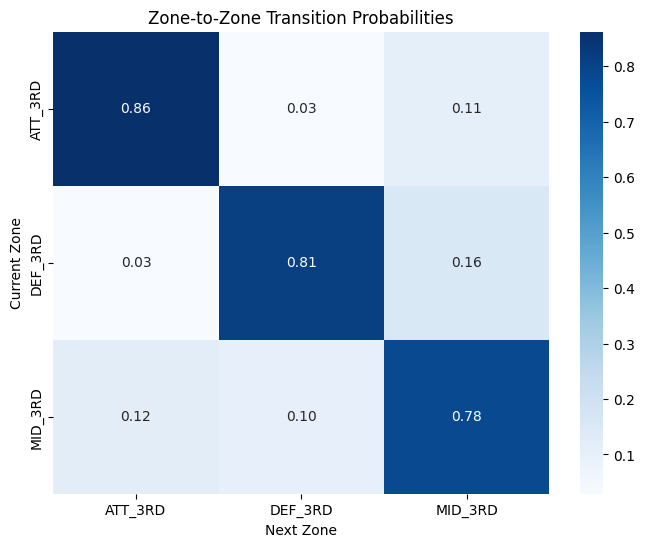

In [9]:
plt.figure(figsize=(8,6))
sns.heatmap(transition_probs, annot=True, cmap="Blues", fmt=".2f")
plt.title("Zone-to-Zone Transition Probabilities")
plt.ylabel("Current Zone")
plt.xlabel("Next Zone")
plt.show()
